# Digital Assyriology

## Day 1

In [24]:
%pylab inline
from datascience import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['DateFormatter', 'Formatter', 'percentile', 'Circle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Notes

- Changed all [he, she] into [he/ she]
- Changed all [itself, themselves] to [itself/ themselves]

### Getting Started

We first import our data into a table.

In [25]:
# We read in our data from `Enmerkat.txt`, and seperate entries by commas.
Enmerkar_table = Table.read_table('Enmerkar.txt', sep = ',')


Enmerkar_table = Enmerkar_table.drop(['text_name', 'etcsl_no'])

# We display the table below
Enmerkar_table

text_name,l_no,text
Enmerkar and En-suhgir-ana,1,sux:šeg₁₂[brick(work)]N sux:kur[(mountain) land]N sux:šu ...
Enmerkar and En-suhgir-ana,2,sux:Kulaba[1]SN sux:iri[town]N sux:an[heaven]N sux:ki[pl ...
Enmerkar and En-suhgir-ana,3,sux:Unug[1]SN sux:mu[name]N sux:tir-an-na[rainbow]N
Enmerkar and En-suhgir-ana,4,sux:an[heaven]N sux:us₂[to be adjacent]V sux:si-muš₃[bri ...
Enmerkar and En-suhgir-ana,5,sux:an[heaven]N sux:gub[to stand]V sux:ud-sakar[crescent ...
Enmerkar and En-suhgir-ana,6,sux:me[essence]N sux:gal[to be big]V sux:nam-nun[princel ...
Enmerkar and En-suhgir-ana,7,sux:kur[(mountain) land]N sux:sikil[to be pure]V sux:ud[ ...
Enmerkar and En-suhgir-ana,8,sux:itid[moon(light)]N sux:kalam[the Land]N sux:e₃[to go ...
Enmerkar and En-suhgir-ana,9,sux:ud[day(light)]N sux:zalag[to be shining]V sux:kalam[ ...
Enmerkar and En-suhgir-ana,10,sux:ab₂-ur₃[rear cow]N sux:ab₂-saharₓ[type of cow]N sux: ...


## Sanitizing Input

### Deleting Spaces

We ensure that the labels of our table do not have spaces. We define the function `remove_space_from_labels` which works for all tables.

In [26]:
def remove_space_from_labels(table):
    for label in table.labels:
        table.relabel(label, label.replace(' ', ''))
    return table

Enmerkar_table = remove_space_from_labels(Enmerkar_table)

Enmerkar_table.labels

('text_name', 'l_no', 'text')

### Valid Line Numbers

We ensure we are only working with valid data: We drop rows of our table where the `l_no` field contains letters.

In [34]:
# drop rows of different translations
to_be_kept = []

# We iterate through fields in the column `l_no`
for i in Enmerkar_table['l_no']:
    # We check if the label of a row contains a letter
    if re.search('[a-zA-Z]', i):
        # Here, we add an entry `False` to the list we created above, `to_be_dropped`
        to_be_kept.append(False)
    else:
        # If the entry did not contain a letter, we append true to our list
        to_be_kept.append(True)        
        
# We drop the columns selected above
Enmerkar_table = Enmerkar_table.where(to_be_kept)

Enmerkar_table

text_name,l_no,text
Enmerkar and En-suhgir-ana,1,sux:šeg₁₂[brick(work)]N sux:kur[(mountain) land]N sux:šu ...
Enmerkar and En-suhgir-ana,2,sux:Kulaba[1]SN sux:iri[town]N sux:an[heaven]N sux:ki[pl ...
Enmerkar and En-suhgir-ana,3,sux:Unug[1]SN sux:mu[name]N sux:tir-an-na[rainbow]N
Enmerkar and En-suhgir-ana,4,sux:an[heaven]N sux:us₂[to be adjacent]V sux:si-muš₃[bri ...
Enmerkar and En-suhgir-ana,5,sux:an[heaven]N sux:gub[to stand]V sux:ud-sakar[crescent ...
Enmerkar and En-suhgir-ana,6,sux:me[essence]N sux:gal[to be big]V sux:nam-nun[princel ...
Enmerkar and En-suhgir-ana,7,sux:kur[(mountain) land]N sux:sikil[to be pure]V sux:ud[ ...
Enmerkar and En-suhgir-ana,8,sux:itid[moon(light)]N sux:kalam[the Land]N sux:e₃[to go ...
Enmerkar and En-suhgir-ana,9,sux:ud[day(light)]N sux:zalag[to be shining]V sux:kalam[ ...
Enmerkar and En-suhgir-ana,10,sux:ab₂-ur₃[rear cow]N sux:ab₂-saharₓ[type of cow]N sux: ...


## Text Analysis

Here, we define dictionaries mapping abbreviations ('CN') to full length phrases. 

In [37]:
proper_nouns = {
'CN': 'Constellation Name (star)',
'DN': 'Deity Name',
'EN': 'Ethnicity Name',
'FN': 'Field Name',
'GN': 'Geographical Name (for regions and countries)',
'MN': 'Month Name',
'ON': 'Object Name (usually for objects associated with a god)',
'PN': 'Personal Name',
'RN': 'Royal Name',
'SN': 'Settlement Name',
'TN': 'Temple Name',
'WN': 'Water Name',
}

simple_terms = {
    'AJ': 'Adjective',
    'AV': 'Adverb',
    'C': 'Conjunction',
    'N': 'Noun',
    'NU': 'Number',
    'PD': 'Part of Speech',
    'V': 'Verb',
}

### Analyzing Proper Nouns and Speech Articles in text

We define a few helper functions below.

In [38]:
# returns the meanings of words in a line of text
def term_finder (line):
    # We filter out terms from the line, which is represented as a String
    # We look for substrings which contain left and right brackets
    terms = re.findall(r"(?<=\[)(.*?)(?=\])", line)
    return terms

# returns a list of all the proper nouns in a line of text
def proper_noun_finder(line):
    # We look for substrings which start with a colon and end with a right bracket
    nouns = re.findall(r"(?<=\:)(.*?)(?=\[)", line)
    
    # We make sure the proper noun is valid, which is if it has length greater than 1
    # and if the first character is upper case while the second isn't
    nouns = [word for word in nouns if (len(word) > 1 and word[0].isupper() and not word[1].isupper())]
    return nouns

#returns the speech articles for proper_nouns or all words
def speech_article_finder(line, proper_noun_filter = True):
    # We look for substrings which start with a left bracket and end with some whitespace
    terms = re.findall(r"(?<=\])(.*?)(?=\s)", line)
    if proper_noun_filter:
        # If we only want proper nouns, we match the terms we found to the list of proper nouns
        # Then, we only select those which are on our list of proper nouns
        articles = [term for term in terms if term in proper_nouns]
    else: 
        articles = terms
    return articles


Here, we use the functions defined above to update our table. Read the functions above to understand how it all happened!

In [39]:
Enmerkar_table = Enmerkar_table.with_columns([
    # We create a column `terms` by applying the `term-finder` function defined above to the data in the text column
    'terms', Enmerkar_table.apply(term_finder, 'text'), 
    # We create the proper-nouns column from the function `proper-noun-finder` applied to the text column
    'proper_nouns', Enmerkar_table.apply(proper_noun_finder, 'text'), 
    # We create the `speech_articles` column from the function `speech_article_finder` applied to the text column
    'speech_articles', Enmerkar_table.apply(speech_article_finder, 'text')
    ])

Enmerkar_table.show()

text_name,l_no,text,terms,proper_nouns,speech_articles
Enmerkar and En-suhgir-ana,1,sux:šeg₁₂[brick(work)]N sux:kur[(mountain) land]N sux:šu ...,"['brick(work)', '(mountain) land', 'shining', 'to go out ...",[],[]
Enmerkar and En-suhgir-ana,2,sux:Kulaba[1]SN sux:iri[town]N sux:an[heaven]N sux:ki[pl ...,"['1', 'town', 'heaven', 'place', 'to grow']",['Kulaba'],['SN']
Enmerkar and En-suhgir-ana,3,sux:Unug[1]SN sux:mu[name]N sux:tir-an-na[rainbow]N,"['1', 'name', 'rainbow']",['Unug'],['SN']
Enmerkar and En-suhgir-ana,4,sux:an[heaven]N sux:us₂[to be adjacent]V sux:si-muš₃[bri ...,"['heaven', 'to be adjacent', 'brilliance', 'to be multic ...",[],[]
Enmerkar and En-suhgir-ana,5,sux:an[heaven]N sux:gub[to stand]V sux:ud-sakar[crescent ...,"['heaven', 'to stand', 'crescent (moon)', 'to be new', ' ...",[],[]
Enmerkar and En-suhgir-ana,6,sux:me[essence]N sux:gal[to be big]V sux:nam-nun[princel ...,"['essence', 'to be big', 'princeliness', 'to erect']",[],[]
Enmerkar and En-suhgir-ana,7,sux:kur[(mountain) land]N sux:sikil[to be pure]V sux:ud[ ...,"['(mountain) land', 'to be pure', 'day(light)', 'to be g ...",[],[]
Enmerkar and En-suhgir-ana,8,sux:itid[moon(light)]N sux:kalam[the Land]N sux:e₃[to go ...,"['moon(light)', 'the Land', 'to go out or in']",[],[]
Enmerkar and En-suhgir-ana,9,sux:ud[day(light)]N sux:zalag[to be shining]V sux:kalam[ ...,"['day(light)', 'to be shining', 'the Land', 'horn', 'to ...",[],[]
Enmerkar and En-suhgir-ana,10,sux:ab₂-ur₃[rear cow]N sux:ab₂-saharₓ[type of cow]N sux: ...,"['rear cow', 'type of cow', 'abundance', 'to go out or in']",[],[]


### Determining Sections

Here, we define a helper function which helps us determine which section each line belongs to, based on the line number.

In [41]:
def partitioning(line_no):
    
    ln = int(''.join(c for c in line_no if c.isdigit()))

    if(ln <= 13):
        return "1.1"
    elif (ln <= 21):
        return "1.2"
    
    elif (ln <= 39):
        return "2.1.1"
    elif (ln <= 51):
        return "2.1.2"
    elif (ln <= 69):
        return "2.1.3"
    
    elif (ln <= 76):
        return "2.2.1"
    elif (ln <= 90):
        return "2.2.2"
    elif (ln <= 113):
        return "2.2.3"
    
    elif (ln <= 127):
        return "2.3.1"
    elif (ln <= 132):
        return "2.3.2"
    elif (ln <= 134):
        return "2.3.3"
    
    elif (ln <= 138):
        return "3.1.1"
    elif (ln <= 149):
        return "3.1.2"
    elif (ln <= 162):
        return "3.1.3"
    elif (ln <= 169):
        return "3.1.4"
    
    elif (ln <= 184):
        return "3.2.1"
    elif (ln <= 197):
        return "3.2.2"
    elif (ln <= 205):
        return "3.2.3"
    elif (ln <= 210):
        return "3.2.4"
    elif (ln <= 221):
        return "3.2.5"
    
    elif (ln <= 227):
        return "4.1"
    
    elif (ln <= 248):
        return "4.2.1"
    elif (ln <= 254):
        return "4.2.2"
    elif (ln <= 263):
        return "4.2.3"
    elif (ln <= 273):
        return "4.2.4"
    
    elif (ln <= 280):
        return "5.1"
    elif (ln <= 283):
        return "5.2"
    elif (ln <= 310):
        return "B"
    return "0"

def small_partition(line_no):
    ln = int(''.join(c for c in line_no if c.isdigit()))
    if(ln <= 13):
        return "1.1"
    elif (ln <= 21):
        return "1.2"
    elif (ln <= 69):
        return "2.1"
    elif (ln <= 113):
        return "2.2"
    elif (ln <= 134):
        return "2.3"
    elif (ln <= 169):
        return "3.1"
    elif (ln <= 221):
        return "3.2"
    elif (ln <= 227):
        return "4.1"
    elif (ln <= 273):
        return "4.2"
    elif (ln <= 280):
        return "5.1"
    elif (ln <= 283):
        return "5.2"
    elif (ln <= 310):
        return "6"
    return "0"

We apply the function defined above on our table.

In [48]:
# We create the column called `section` by applying our `partion` function
Enmerkar_table.append_column('section', Enmerkar_table.apply(partitioning, 'l_no'))

# We create a smaller table by selected only three columns
Enmerkar_graph = Enmerkar_table.select(['proper_nouns', 'speech_articles', 'section']).group('section', list)

# displays the table
Enmerkar_graph

section,proper_nouns list,speech_articles list
1.1,"[[], ['Kulaba'], ['Unug'], [], [], [], [], [], [], [], [ ...","[[], ['SN'], ['SN'], [], [], [], [], [], [], [], ['SN'], ..."
1.2,"[['Utu'], ['Aratta', 'Ansiga-ria'], ['Enmerkar', 'Kulaba ...","[['DN'], ['SN', 'PN'], ['RN', 'SN', 'PN'], [], [], [], [ ..."
2.1.1,"[['Unug', 'Kulaba'], ['Aratta', 'En-suhgir-ana'], ['Unug ...","[['SN', 'SN'], ['SN'], ['SN'], [], [], ['DN'], ['DN', 'T ..."
2.1.2,"[[], [], [], [], [], ['Šakkan'], [], [], [], [], [], []]","[[], [], [], [], [], ['DN'], [], [], [], [], [], []]"
2.1.3,"[[], [], ['Aratta', 'En-suhgir-ana'], [], [], [], ['Inan ...","[[], [], ['SN', 'RN'], [], [], [], ['DN'], ['DN', 'TN', ..."
2.2.1,"[['Unug'], [], [], [], ['Aratta'], ['Aratta'], []]","[['SN'], [], [], [], ['SN'], ['SN'], []]"
2.2.2,"[[], ['Inana', 'E-zagin', 'Aratta'], [], [], ['Inana'], ...","[[], ['DN', 'TN', 'SN'], [], [], ['DN'], [], [], [], [], ..."
2.2.3,"[['Enlil'], ['Ninurta', 'Enlil'], [], ['Aruru', 'Enlil'] ...","[['DN'], ['DN'], [], ['DN'], [], [], ['DN'], [], [], [], ..."
2.3.1,"[['Enmerkar', 'En-suhgir-ana'], [], [], ['En-suhgir-ana' ...","[['RN'], [], [], ['RN'], [], [], [], ['SN', 'SN'], [], [ ..."
2.3.2,"[[], ['Unug'], ['Enmerkar'], ['Enmerkar'], []]","[[], ['SN'], ['RN'], ['RN'], []]"


### Understanding Data

Notice that in the table above, the columns `proper_nouns list` and `speech_articles list` actually contain a list of lists. We "flatten" this list of lists to create a single list. Run the cell below to see what happens!

In [49]:
def list_flattening(pn_list):
    return [noun for nouns in pn_list for noun in nouns]

# First, we flatten the speech articles column
Enmerkar_graph.append_column('speech articles', Enmerkar_graph.apply(list_flattening, 'speech_articles list'))

# Now, we flatten the proper nouns column
Enmerkar_graph.append_column('proper nouns', Enmerkar_graph.apply(list_flattening, 'proper_nouns list'))

# We discard the old columns
Enmerkar_graph = Enmerkar_graph.drop(['proper_nouns list', 'speech_articles list'])

# and display below!
Enmerkar_graph

section,speech articles,proper nouns
1.1,"['SN', 'SN', 'SN', 'SN']","['Kulaba', 'Unug', 'Unug', 'Aratta']"
1.2,"['DN', 'SN', 'PN', 'RN', 'SN', 'PN']","['Utu', 'Aratta', 'Ansiga-ria', 'Enmerkar', 'Kulaba', 'N ..."
2.1.1,"['SN', 'SN', 'SN', 'SN', 'DN', 'DN', 'TN', 'SN', 'DN', ' ...","['Unug', 'Kulaba', 'Aratta', 'En-suhgir-ana', 'Unug', 'I ..."
2.1.2,['DN'],['Šakkan']
2.1.3,"['SN', 'RN', 'DN', 'DN', 'TN', 'SN', 'DN', 'DN']","['Aratta', 'En-suhgir-ana', 'Inana', 'Inana', 'E-zagin', ..."
2.2.1,"['SN', 'SN', 'SN']","['Unug', 'Aratta', 'Aratta']"
2.2.2,"['DN', 'TN', 'SN', 'DN', 'DN', 'DN']","['Inana', 'E-zagin', 'Aratta', 'Inana', 'Inana', 'Utu']"
2.2.3,"['DN', 'DN', 'DN', 'DN', 'DN', 'SN', 'SN', 'SN', 'SN', ' ...","['Enlil', 'Ninurta', 'Enlil', 'Aruru', 'Enlil', 'Anzud', ..."
2.3.1,"['RN', 'RN', 'SN', 'SN', 'SN', 'SN', 'SN']","['Enmerkar', 'En-suhgir-ana', 'En-suhgir-ana', 'Unug', ' ..."
2.3.2,"['SN', 'RN', 'RN']","['Unug', 'Enmerkar', 'Enmerkar']"


### Examining Data

Here, we create a new table which exmaines the correlation between speech articles and proper nouns.

We define the function partitioner which will split the speech articles and proper nouns lists into individual rows.

In [62]:
def partitioner (i):
    rows = []
    section = Enmerkar_graph['section'][i]
    speech_articles = Enmerkar_graph['speech articles'][i]
    proper_nouns = Enmerkar_graph['proper nouns'][i]
    for j in range(len(speech_articles)):
        article = speech_articles[j]
        proper_noun = proper_nouns[j]
        rows.append([section, article, proper_noun])
    return rows

Enmerkar_table_section = Table(['section', 'speech articles', 'proper nouns'])
# We run the partitioner on each row in our table
for i in range(Enmerkar_graph.num_rows):
    Enmerkar_table_section = Enmerkar_table_section.with_rows(partitioner(i))
Enmerkar_table_section

section,speech articles,proper nouns
1.1,SN,Kulaba
1.1,SN,Unug
1.1,SN,Unug
1.1,SN,Aratta
1.2,DN,Utu
1.2,SN,Aratta
1.2,PN,Ansiga-ria
1.2,RN,Enmerkar
1.2,SN,Kulaba
1.2,PN,Namena-tuma


### Grouping by Proper Noun

Now, we will determine the frequency of Proper Nouns based on the number of rows they appeared in, in the table above

In [72]:
proper_noun_by_section = Enmerkar_table_section.pivot('proper nouns', rows = 'section')
name_counts = []
for name in proper_noun_by_section.drop('section').labels:
    # Here, we add an entry to our list `name_counts` defined above
    # which is a list of the form: ['Proper_noun', # of entries]
    name_counts.append([name, np.sum(proper_noun_by_section[name])])

top_7_names = ['Aratta', 'En-suhgir-ana', 'Enmerkar', 'Inana', 'Nisaba', 'Saŋburu', 'Unug']

# We display the sorted list below
sorted(name_counts, key = lambda x: x[1], reverse = True)

[['Unug', 17],
 ['Aratta', 16],
 ['Inana', 14],
 ['Nisaba', 11],
 ['Saŋburu', 9],
 ['En-suhgir-ana', 7],
 ['Enmerkar', 7],
 ['Kulaba', 6],
 ['Ansiga-ria', 5],
 ['E-zagin', 5],
 ['Enlil', 4],
 ['Ereš', 4],
 ['Utu', 4],
 ['Hamazi', 3],
 ['Euphrates', 2],
 ['Ur-ŋiri-nuna', 2],
 ['An', 1],
 ['Anzud', 1],
 ['Aruru', 1],
 ['E-ana', 1],
 ['Maš-gula', 1],
 ['Namena-tuma', 1],
 ['Nanna', 1],
 ['Ninurta', 1],
 ['Ur-edina', 1],
 ['Šakkan', 1]]

## Displaying Data

Now, we create a line graph which will show us the frequency of the proper nouns "Aratta" and "Unug" in each section.

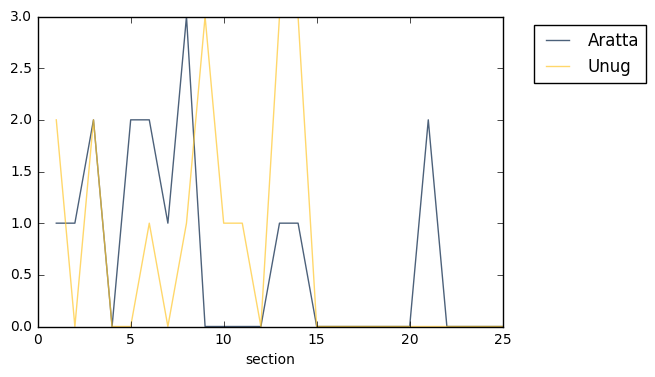

In [52]:
names_section_graph = proper_noun_by_section.with_column('section', range(1, proper_noun_by_section.num_rows+1))

aratta_unug_section_graph = names_section_graph.select(['Aratta', 'Unug', 'section']).plot('section')
#notice Aratta is the only one mentioned in the section 4.2.3

We do the same as above, but now for the top 7 proper nouns.

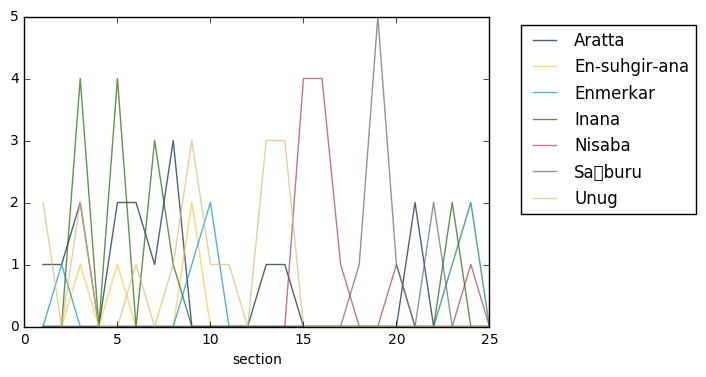

In [53]:
top_7_names_graph = names_section_graph.select(top_7_names + ['section']).plot('section')

Here, we display all the proper nouns.

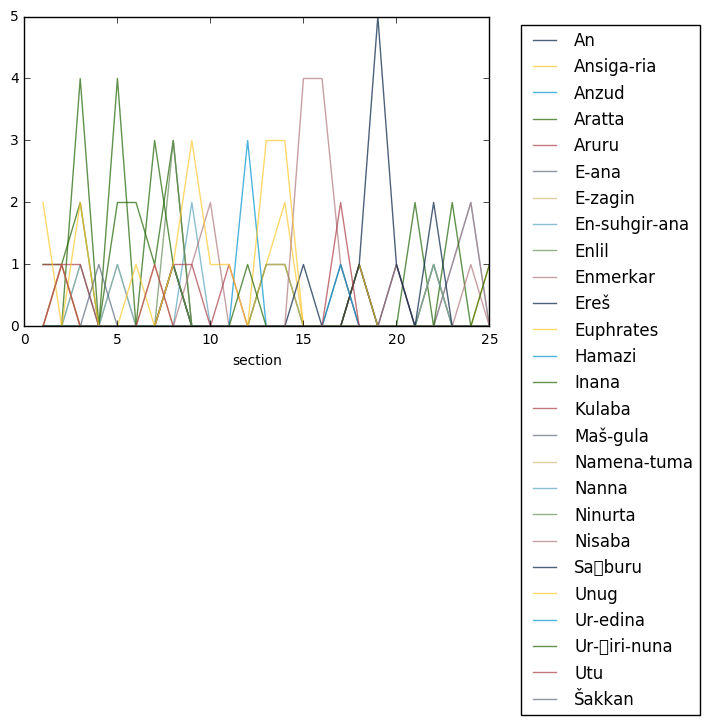

In [54]:
names_section_graph.plot('section')

## Plot character arcs by line number

In [55]:
# Import more functions
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

We define a helper function which counts the number of each noun in the list `noun`, in our list of nouns `proper nouns`.

In [56]:
def noun_counts(noun, proper_nouns):
    noun_count = []
    # We iterate through the list proper_nouns
    for i in np.arange(len(proper_nouns)):
        # We count the number of times each entry in `noun` appeared in the proper_nouns entry
        noun_count.append(proper_nouns[i].count(noun))
    return noun_count

Now, we apply `noun_counts` to the tables we created above.

In [57]:
# We select only the line number and proper_nouns from our table
names_cumulative_graph = Enmerkar_table.select(['l_no', 'proper_nouns'])

# We create a list of unique proper nouns
unique_nouns = np.sort(list(set(list_flattening(names_cumulative_graph.column('proper_nouns')))))
for i in np.arange(1, len(unique_nouns)+1):
    # We select a noun to look at
    current_noun = unique_nouns[i-1]
    # We add a column to the table `names_cumulative_graph` which gives a running count of the appearance of the proper noun
    names_cumulative_graph.append_column(current_noun, np.cumsum(noun_counts(current_noun, names_cumulative_graph.column('proper_nouns'))))

# We drop the column `proper_noun`
names_cumulative_graph = names_cumulative_graph.drop('proper_nouns')

We define more helper functions so we can visualize the data below.

In [73]:
def plot(name, graph, prefix):
    if name != 'None':
        line_graph = graph.select([prefix] + [name])
        plt.plot(line_graph[0], line_graph[1])
        
def plot_cumulative_characters(name1, name2, name3, name4):
        plot(name1, names_cumulative_graph, 'l_no')
        plot(name2, names_cumulative_graph, 'l_no')
        plot(name3, names_cumulative_graph, 'l_no')
        plot(name4, names_cumulative_graph, 'l_no')
        
def plot_section_characters(name1, name2, name3, name4):
        plot(name1, names_section_graph, 'section')
        plot(name2, names_section_graph, 'section')
        plot(name3, names_section_graph, 'section')
        plot(name4, names_section_graph, 'section')
    
unique_nouns = tuple(['None'] + list(unique_nouns))

## Visualizing Data

Here, compare the usage of different proper nouns by their cumulative apperance across the text.

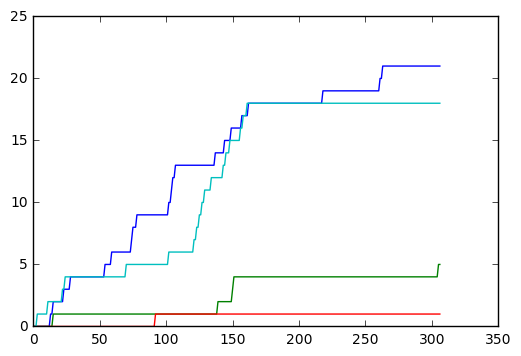

In [59]:
interact(plot_cumulative_characters, name1=unique_nouns, name2=unique_nouns, name3=unique_nouns, name4=unique_nouns)

Now, compare the nouns by apperance in the various sections

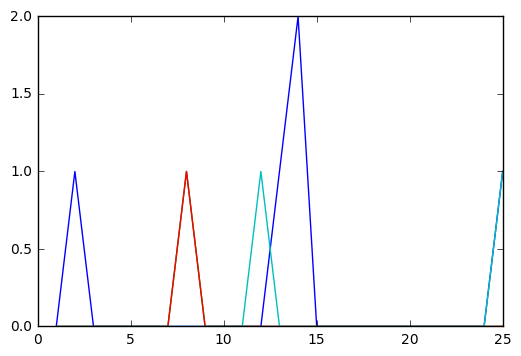

In [60]:
interact(plot_section_characters, name1=unique_nouns, name2=unique_nouns, name3=unique_nouns, name4=unique_nouns)